In [1]:
import random
import numpy as np
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh
from scipy.stats import spearmanr, kendalltau, pearsonr
from tqdm import *
from sklearn.manifold import SpectralEmbedding

In [ ]:
def heat_plot(data):

    plt.figure(figsize=(4, 4))
    plt.imshow(data,interpolation='nearest')
    plt.colorbar()

    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])  
    plt.axis('off')
    # plt.show()

def read_txt_file(filename):
  with open(filename, 'r') as f:
    lines = f.readlines()
  cleaned_lines = [line.strip() for line in lines]
  array_data = np.array(cleaned_lines, dtype=float)  # 修改dtype根据需要
  return list(array_data)

In [ ]:
def laplacian_embedding(x):
  embedder = SpectralEmbedding(n_components=1)
  x_transformed = embedder.fit_transform(x)
  return x_transformed[:, 0]

def corr_matrix(data, corr_type):
  mat = np.copy(data)
  count = 0

  if corr_type == 'Pearson':
    correlation_matrix = np.ones((mat.shape[1], mat.shape[1]))
    for i in range(mat.shape[1]):
      for j in range(i + 1, mat.shape[1]):
        if np.all(mat[:, i] == mat[0, i]) or np.all(mat[:, j] == mat[0, j]):
          correlation_matrix[i][j] = 0
          correlation_matrix[j][i] = 0
        else:
          correlation_matrix[i][j], _ = pearsonr(mat[:, i], mat[:, j])
          correlation_matrix[j][i] = correlation_matrix[i][j]
        if _ > 0.01:
          count += 1
  elif corr_type == 'Spearmanr':
    correlation_matrix, _ = spearmanr(mat)
    for i in range(mat.shape[1]):
      for j in range(i + 1, mat.shape[1]):
        if _[i, j] > 0.01:
          count += 1
  elif corr_type == 'Kendalltau':
    correlation_matrix = np.ones((mat.shape[1], mat.shape[1]))
    for i in range(mat.shape[1]):
      for j in range(i + 1, mat.shape[1]):
        correlation_matrix[i][j], _ = kendalltau(mat[:, i], mat[:, j])
        correlation_matrix[j][i] = correlation_matrix[i][j]
        if _ > 0.01:
          count += 1
  else:
    print("no such type corr_matrix")
    return 0

  return correlation_matrix, count


def rank_array(arr):
  sorted_indices = sorted(range(len(arr)), key=lambda k: arr[k])
  ranks = [0] * len(arr)
  for i, idx in enumerate(sorted_indices):
    ranks[idx] = i
  return ranks

In [ ]:
def reorder_data(data, scale_factor=1.0):

  data = data[:int(data.shape[0]*0.7),:]
  corr_mx, count = corr_matrix(data, 'Pearson')
  adj_mx = abs(corr_mx)

  # s_mx0 = np.copy((1/(1+np.exp(active_num*(-adj_mx+1/2)))-1/(1+np.exp(active_num/2)))/(1/(1+np.exp(-active_num/2))-1/(1+np.exp(active_num/2))))
  s_mx0 = np.exp(adj_mx/scale_factor)
  heat_plot(s_mx0)
  s_order = laplacian_embedding(s_mx0)
  s_ranks = rank_array(s_order)
  s_list0 = list(s_ranks)

  dist_new = np.copy(s_mx0)
  for i in range(data.shape[1]):
    for j in range(data.shape[1]):
      dist_new[i,j] = s_mx0[s_list0.index(i),s_list0.index(j)]

  heat_plot(dist_new)

  return s_list0, s_mx0, dist_new

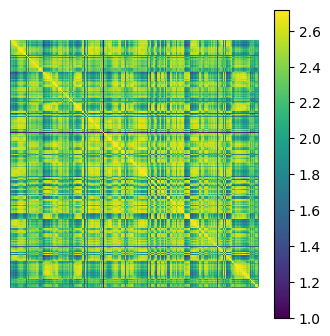

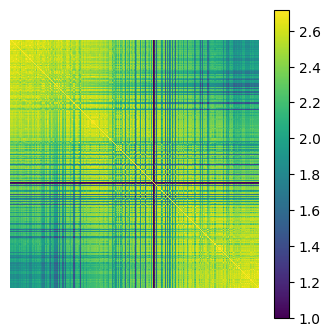

In [ ]:
root_path = 'Data/datasets'
data_path = 'kddcup.csv'

data_file = os.path.join(root_path, data_path)

d_list,s_mx0,dist_new = reorder_data(pd.read_csv(data_file).values)
np.save('Data/order/kddcup_pro.npy', d_list)
emb = []
for i in range(len(d_list)):
    emb.append(d_list.index(i))
np.save('Data/order/kddcup_emb.npy',emb)